# Imports


In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os
from pathlib import Path
os.chdir(Path(os.path.abspath("C:/Users/45938/Desktop/Autonomous Systems/Deep Learning/Siham/Project/mros-data-main")))
from mros_data.datamodule import SleepEventDataModule

# Datamodule

The `SleepEventDataModule` class contains logic to iterate over event data by wrapping a `SleepEventDataset` class.
The datamodule is also responsible for splitting the data into train/eval partitions using the `setup()` method, and the user can then get a PyTorch `DataLoader` for each partition from the respective `*_dataloader()` methods.

## Instantiate class

We pass a dictionary of parameters to the datamodule class in order to instantiate it.
The only event-specific parameters of note are `events`, `default_event_window_duration`, `fs`, and `picks`, corresponding to the event code/event name, duration of default events, sampling frequency, and the specific channels to include.

Any transformations of the input data, such as short-time Fourier or continuous wavelet transforms can be included by the `transform` parameter.

In [20]:
from mros_data.datamodule.transforms import STFTTransform
params = dict(
    data_dir="C:/Users/45938/Desktop/Autonomous Systems/Deep Learning/Siham/Project/processed/mros/lm",
    batch_size=16,
    n_eval=2,
    n_test=2,
    num_workers=0,
    seed=1337,
    events={"lm": "Leg movement"},
    window_duration=600,  # seconds
    cache_data=True,
    default_event_window_duration=[15],
    event_buffer_duration=3,
    factor_overlap=2,
    fs=64,
    matching_overlap=0.5,
    n_jobs=-1,
    n_records=10,
    picks=["legl", "legr"],
    # transform=MultitaperTransform(128, 0.5, 35.0, tw=8.0, normalize=True),
    transform=STFTTransform(
        fs=64, segment_size=int(4.0 * 64), step_size=int(0.125 * 64), nfft=1024, normalize=True
    ),
    scaling="robust",
)
dm = SleepEventDataModule(**params)
print(dm)

SleepEventDataModule(data_dir=WindowsPath('C:/Users/45938/Desktop/Autonomous Systems/Deep Learning/Siham/Project/processed/mros/lm'), n_test=2, n_eval=2, seed=1337, events={'lm': 'Leg movement'}, window_duration=600, cache_data=True, default_event_window_duration=[15], event_buffer_duration=3, factor_overlap=2, fs=64, matching_overlap=0.5, n_jobs=-1, n_records=10, picks=['legl', 'legr'], transform=<mros_data.datamodule.transforms.stft_transform.STFTTransform object at 0x00000281D1061D00>, scaling='robust', batch_size=16, num_workers=0)


## Split dataset into train/eval partitions

In [21]:
# The datamodule will split the dataset into train/eval partitions by calling the setup() method.
dm.setup('fit')
train_dl, eval_dl = dm.train_dataloader(), dm.val_dataloader()

# The dataloaders are generators, ie. we can iterate over them using a for-loop.
for i, (data, events, records, *_) in enumerate(train_dl):
    if i < 1:
        print(f'Batch size: {data.shape[0]} | No. channels: {data.shape[1]} | No. timepoints {data.shape[2]} | No. events: {sum([ev.shape[0] for ev in events])} | Data sample size: {list(data.shape[1:])} ')
    break

Using cache for data prep: C:\Users\45938\Desktop\Autonomous Systems\Deep Learning\Siham\Project\mros-data-main\data\.cache


100%|██████████| 6/6 [00:00<00:00, 21.20it/s]


Using cache for data prep: C:\Users\45938\Desktop\Autonomous Systems\Deep Learning\Siham\Project\mros-data-main\data\.cache


100%|██████████| 2/2 [00:00<?, ?it/s]


Batch size: 16 | No. channels: 513 | No. timepoints 4801 | No. events: 244 | Data sample size: [513, 4801] 


C:\Users\45938\Desktop\Autonomous Systems\Deep Learning\Siham\Project\mros-data-main\mros_data\utils\collate_fn.py:20: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:178.)
  batch_stages = torch.stack([torch.IntTensor(el["stages"]) for el in batch])


## Access the underlying datasets

In [22]:
# The underlying data windows can be accessed by indexing into the dataset. This will call the __getitem__() method and yield the signals, and associated events. 
# The events' start times and durations are normalized to the window, ie. an event with elements (0.1, 0.025) in a 10 min window will start at 10 min x 60 s / min x 0.1 = 60 s , and will last 10 min x 60 s / min x 0.025 = 15 s.
train_ds = dm.train
batch = train_ds[1]
record = batch['record']
data = batch['signal']
events = batch['events']
print(batch.keys())
print(f'Record: {record} | No. channels: {data.shape[0]} | No. timepoints: {data.shape[1]} | No. events: {len(events)}')

dict_keys(['signal', 'events', 'stages', 'record', 'localizations_target', 'classifications_target'])
Record: mros-visit1-aa0003 | No. channels: 513 | No. timepoints: 4801 | No. events: 41


## Plotting signals

We can plot signals in the underlying dataset by using the `plot_signals()` method in the `SleepEventDataset`. Simply provide an index in the range `[0, len(dataset)]` and optionally a list of the applied channels:

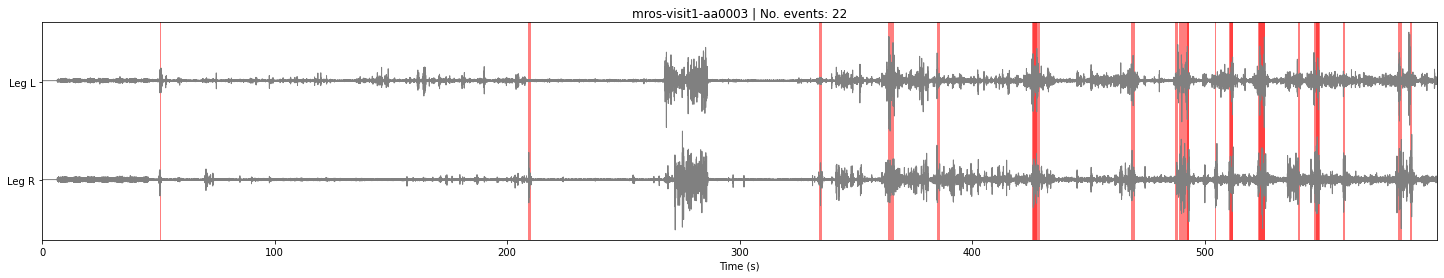

In [23]:
train_ds.plot_signals(0, channel_names=['Leg L', "Leg R"])

## Transforming data on the fly

By using the `transform` argument in the `SleepEventDataModule`, we can get spectrograms of the data as well.

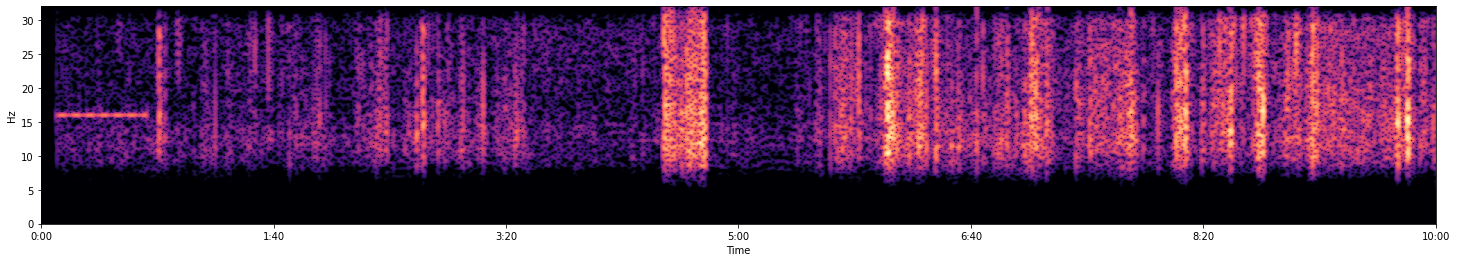

In [24]:
train_ds.plot_spect(0, channel_idx=0, window_size=int(4.0 * train_ds.fs), step_size=int(0.125 * train_ds.fs), nfft=1024)

We can also combine the plots by using the `plot()` method:

In [ ]:
%matplotlib widget
train_ds.plot(0, channel_names=['Leg L', 'Leg R'], channel_idx=0, window_size=int(4.0 * train_ds.fs), step_size=int(0.125 * train_ds.fs), nfft=1024)